In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi
import operator
import deap.benchmarks.tools as bt
import pandas as pd

creator.create("obj", base.Fitness, weights=(-1.0,-1.0, -1.0))
creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'pf': {'min': 0.02, 'max': 0.06},
  'sine_a': {'min': 0.0, 'max': 2.0},
  'sine_b': {'min': 0.0, 'max': 1.57},
  'sine_c': {'min': 0.0, 'max': 6.28},
  'radius_top': {'min': 0.05, 'max': 0.35},
  'radius_bot': {'min': 0.05, 'max': 0.35}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../moltres/python/moltres_xs.py',
     'fhr_plank_gc.inp']],
   'inputs': ['pf', 'sine_a', 'sine_b', 'sine_c', 'radius_top', 'radius_bot'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_plank_openmc_output.py'],
   'outputs': ['pf', 'keff', 'ppf']},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'automate_mesh.py'],
   'execute': [['bash', 'mesh_generate.sh'],
    ['apru

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = logbook.select("gen")
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(15,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation", fontsize=20)
    ax.set_ylabel(obj_name, fontsize=20)
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=18, bbox_to_anchor = [1.0, 1.0])
    ax.set_title(obj_name + " Evolution", fontsize=20)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

In [6]:
logbook = cp["logbook"]

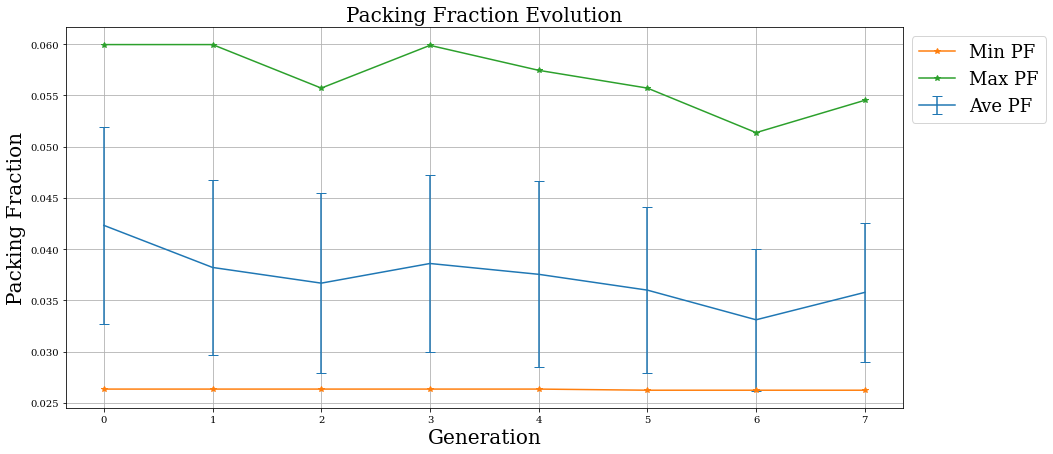

In [7]:
plot_1_obj(logbook, 0, "Packing Fraction", "PF", False, "slab-obj-3-pf-evol.png")

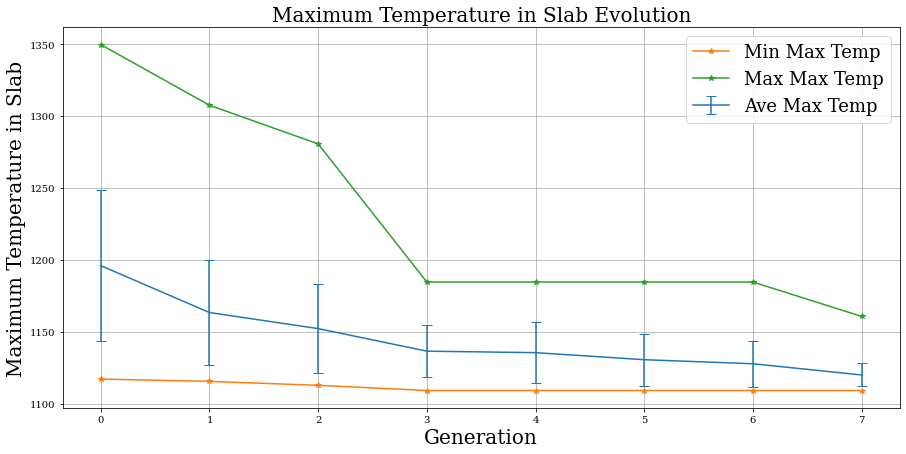

In [8]:
plot_1_obj(logbook, 1, "Maximum Temperature in Slab", "Max Temp", False, "slab-obj-3-temp-evol.png")

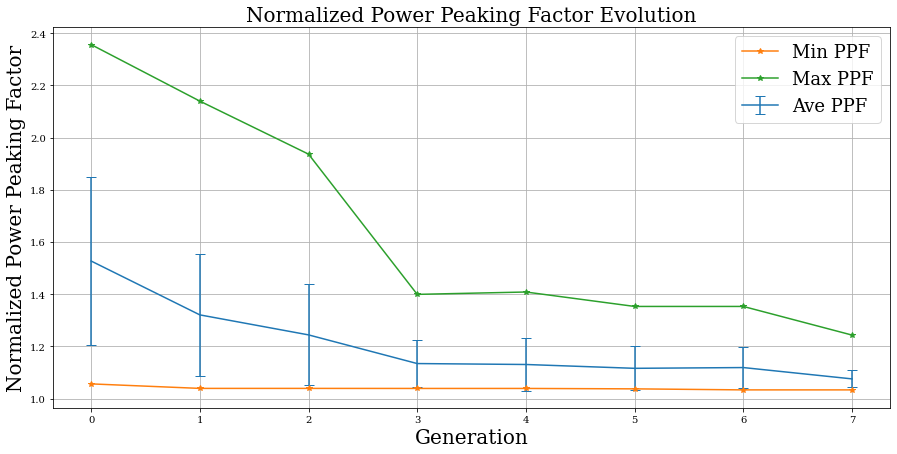

In [9]:
plot_1_obj(logbook, 2, "Normalized Power Peaking Factor", "PPF", False, "slab-obj-3-ppf-evol.png")

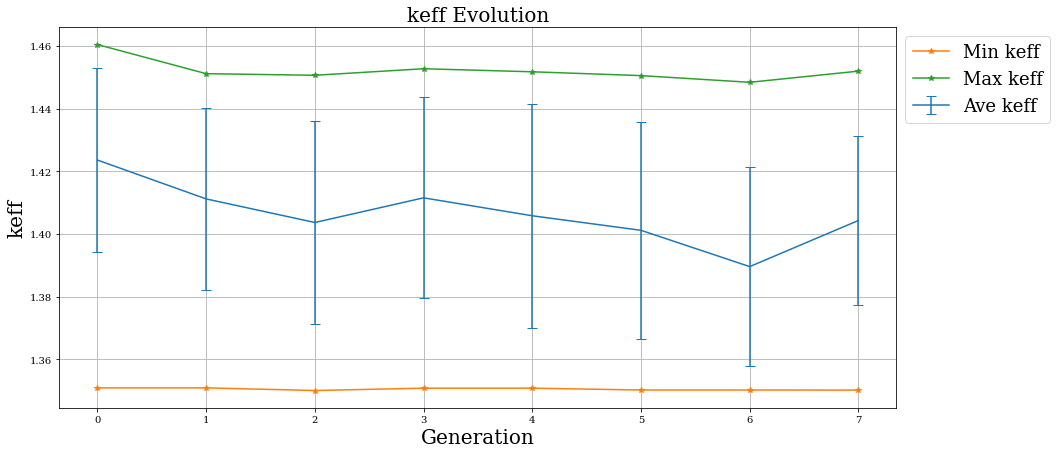

In [10]:
plot_1_obj(logbook, 3, "keff", "keff", False, "")

In [11]:
def sine_curve(ind, pf_present):
    if pf_present:
        pf, a, b, c = ind[0], ind[1], ind[2], ind[3]
    else:
        a, b, c = ind[0], ind[1], ind[2]
        pf = 0.0979
    boundaries = np.arange(2,27.1,2.31)
    midpoints = [] 
    for x in range(len(boundaries)-1):
        midpoints.append((boundaries[x]+boundaries[x+1])/2)
    midpoints = np.array(midpoints)
    x = midpoints
    x1 = np.arange(2, 24.8, 0.01)
    T_pitch = 0.09266
    vol_total = 23.1 * 2.55 * T_pitch * 20
    vol_triso = 4 / 3 * np.pi * 4235e-5 ** 3
    no_trisos = pf * vol_total / vol_triso
    vol_slice = 2.31 * 2.55 * T_pitch * 20
    sine = a * np.sin(b*x + c) + 2
    sine1 = a * np.sin(b*x1 + c) + 2
    sine1 = sine1 / sum(sine) * no_trisos * vol_triso / vol_slice
    sine = sine / sum(sine) * no_trisos * vol_triso / vol_slice
    return x, sine, x1, sine1 

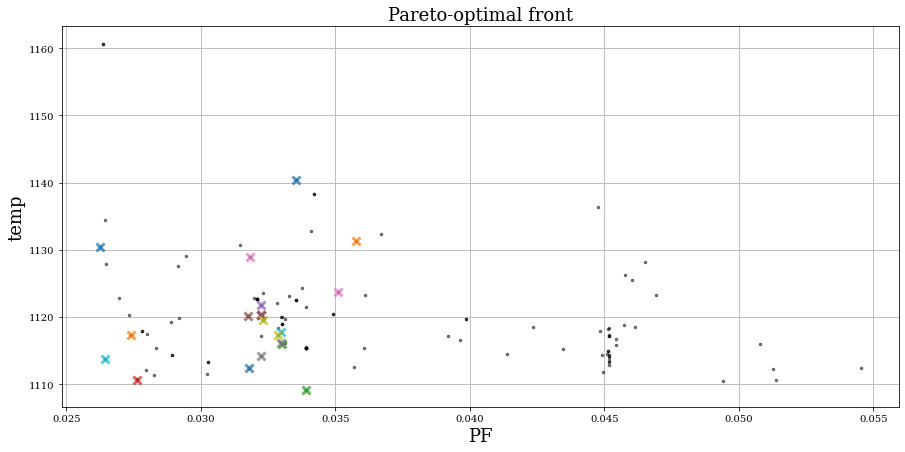

In [12]:
results = cp["all"]
all_pop = []
for p in results["populations"]:
    for i in p:
        all_pop.append(i)
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(15,7))
for ind in pop:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=5, alpha=0.5)
for ind in non_dom:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], 'x', alpha=0.74, ms=8, mew=3)
#ax.set_xlim(0.01, 0.10)
#ax.set_ylim(1.0, 1.6)
ax.set_xlabel('PF',fontsize=18)
ax.set_ylabel('temp',fontsize=18)
ax.set_title('Pareto-optimal front',fontsize=18)
ax.grid()
#plt.savefig("slab-obj-2-pfppf-pareto",bbox_inches='tight')

Text(0.5, 0.9384, "Final Generation's Pareto Front")

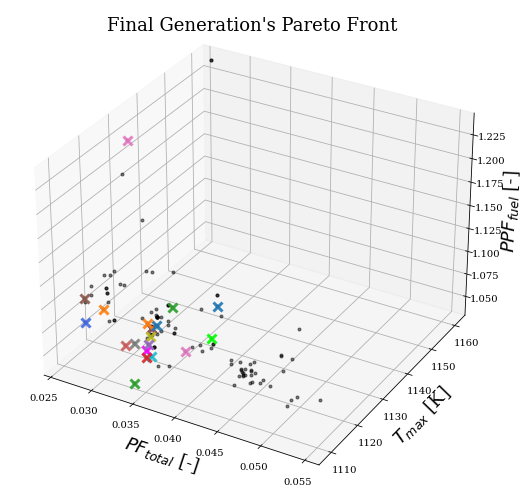

In [13]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(projection='3d')
for ind in pop:
    #if ind.fitness.values[0] < 0.035 and ind.fitness.values[1] < 1190 and ind.fitness.values[2] < 1.15:
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'k.', ms=6, alpha=0.5)
for i, ind in enumerate(non_dom):
    ax.plot(ind.fitness.values[0], ind.fitness.values[1], ind.fitness.values[2], 'x', alpha=0.9, ms=9, mew=3, color=colors[i])
#ax.legend()
ax.grid()
ax.set_xlabel('$PF_{total}$ [-]',fontsize=18)
ax.set_ylabel('$T_{max}$ [K]',fontsize=18)
ax.set_zlabel('$PPF_{fuel}$ [-]', fontsize=18)
ax.set_title("Final Generation's Pareto Front",fontsize=18, y=1.02)
#ax.set_xlim(0.02, 0.035)
#ax.set_xticks([0.02, 0.025, 0.03, 0.035])
#ax.set_ylim(1125, 1200)
#ax.set_yticks([1130, 1150, 1170, 1190])
#ax.set_zlim(1.0, 1.15)
#ax.set_zticks([1.0, 1.05, 1.1, 1.15])
#plt.savefig("slab-obj-3-3d-all.png",bbox_inches='tight')

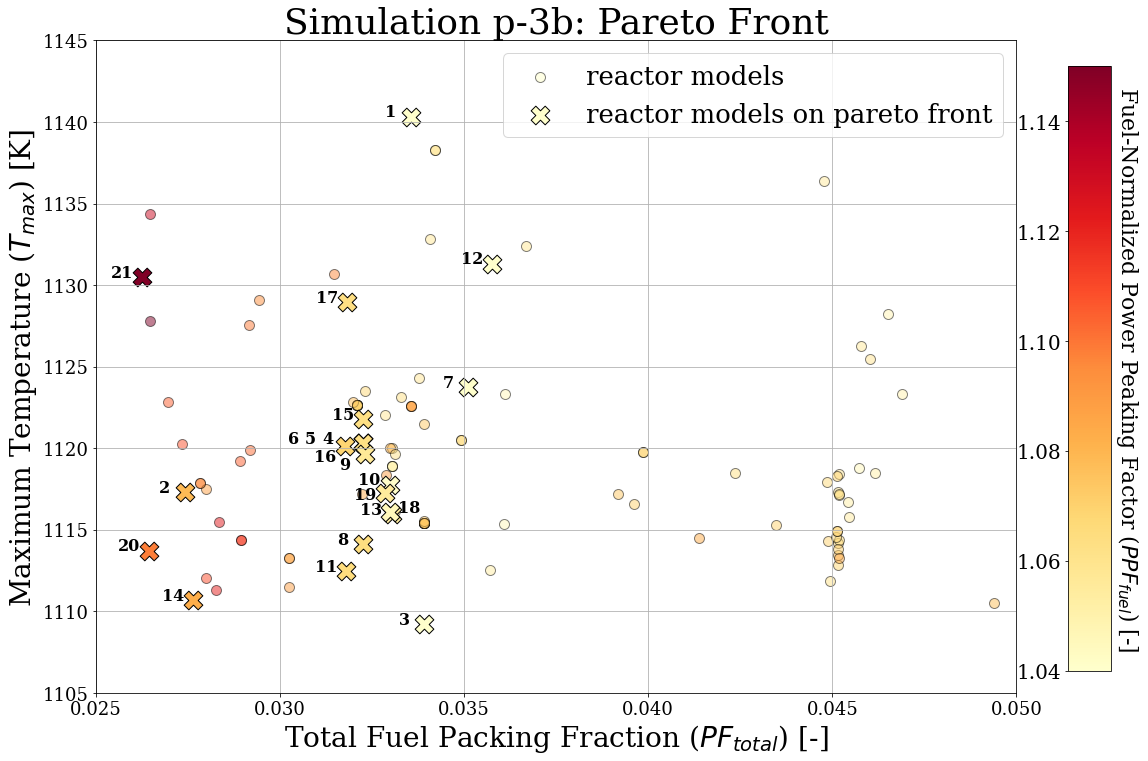

In [14]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "indianred", "lime", "magenta", "royalblue"]*2
results = cp["all"]
pop = results["populations"][-1]
final_non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
fig, ax = plt.subplots(figsize=(12, 12))
count1, count2 = 0, 0
for i, ind in enumerate(pop):
    if count1 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, vmax=1.15, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=0.5, s=100, label="reactor models")
        count1 += 1
    else:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, vmax=1.15, 
                   cmap="YlOrRd", marker='o',edgecolors='black', alpha=0.5, s=100)
prev_0, prev_1 = 0, 0
num = 1
for i, ind in enumerate(final_non_dom):
    if count2 == 0:
        ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, 
                   vmax=1.15, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1, 
                   label="reactor models on pareto front")
        count2 += 1
    else:
        im = ax.scatter(ind.fitness.values[0], ind.fitness.values[1], c=ind.fitness.values[2], vmin=1.04, 
                    vmax=1.15, cmap="YlOrRd", marker="X", s=350, edgecolors='black', alpha=1)
    if num < 100:
        offset_0, offset_1 = abs(ind.output[0]-prev_0), abs(ind.output[1]-prev_1)
        offset_y = 0
        if offset_0 < 0.002 and offset_1 < 0.01:
            if num < 10:
                offset_x -= 17
            else:
                offset_x -= 25
        else:
            offset_x = -20
        if num in [4]:
            offset_x = -35
        if num in [9, 16]:
            offset_y = -15
        if num in [18]:
            offset_x = 20
        if num in [19]:
            offset_y = -7
        ax.annotate(str(num), (ind.output[0], ind.output[1]), textcoords="offset points", 
                    xytext=(offset_x,offset_y), ha='center', weight='bold', fontsize=16) 
        prev_0, prev_1 = ind.output[0], ind.output[1]
    num += 1
ax.grid()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=26, bbox_to_anchor = [1.0, 1.0])
ax.tick_params(axis='both', which='major', labelsize=18)
fig.subplots_adjust(right=1.19)
cbar_ax = fig.add_axes([1.25, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
cbar_ax.yaxis.set_ticks_position('left')
ax.set_xlim([0.025, 0.05])
ax.set_ylim([1105, 1145])
ax.set_ylabel(r'Maximum Temperature ($T_{max}$) [K]',fontsize=28)
ax.set_xlabel(r'Total Fuel Packing Fraction ($PF_{total}$) [-]',fontsize=28)
cb.set_label(r'Fuel-Normalized Power Peaking Factor ($PPF_{fuel}$) [-]', fontsize=22, rotation=270, labelpad=30)
ax.set_title('Simulation p-3b: Pareto Front',fontsize=36)
plt.savefig("slab-obj-3-3d-all.png",bbox_inches='tight')


In [15]:
len(final_non_dom)

21

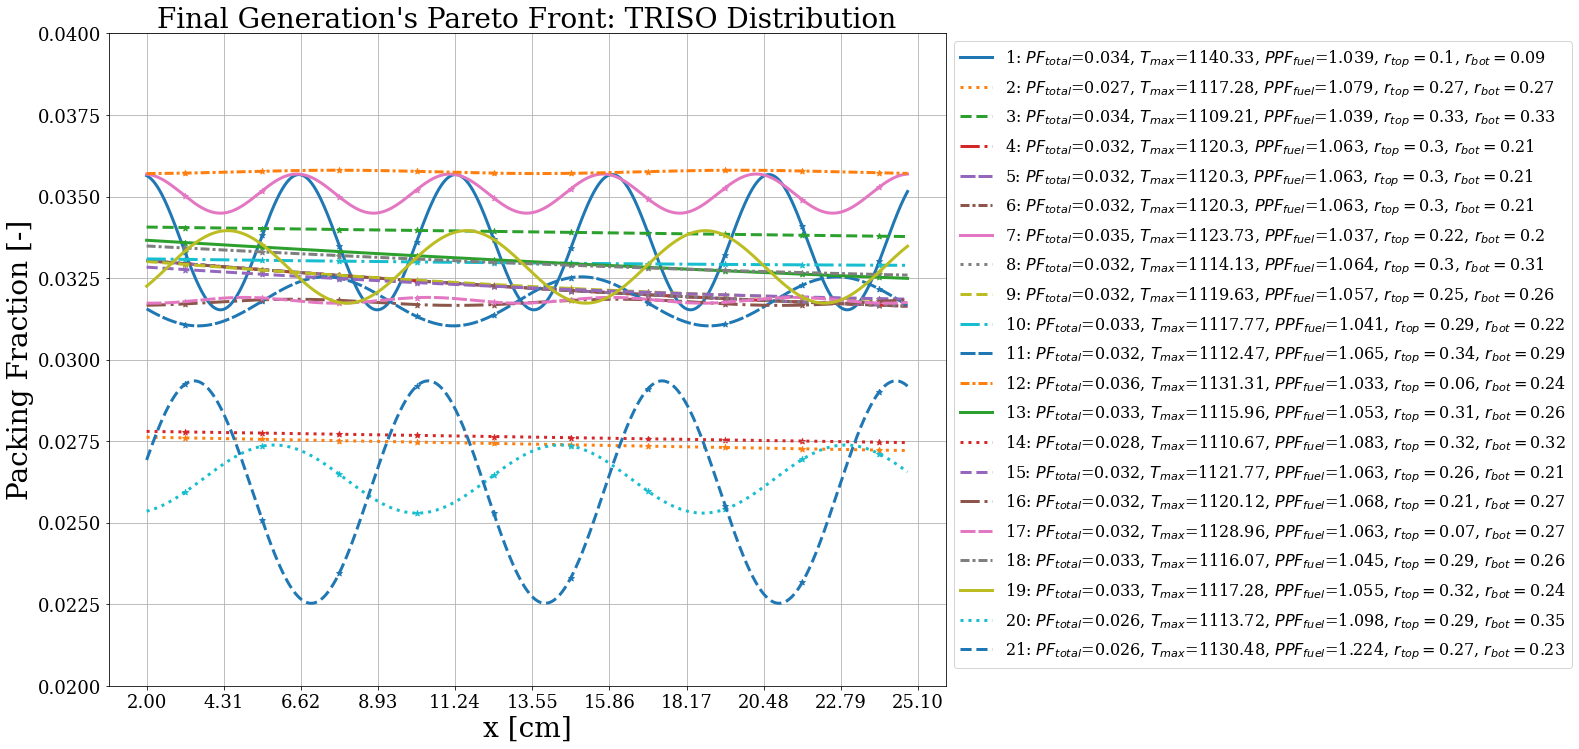

In [16]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
colors = 3*["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan", "tab:blue","tab:orange", "tab:green", "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:gray", "tab:olive", "tab:cyan"]
line_styles = 5*["-", ":", "--", "-.", (0, (5, 1)), (0, (3, 1, 1, 1))]
fig, ax = plt.subplots(figsize=(15,12))
for i, ind in enumerate(non_dom):
    x, sine, x1, sine1 = sine_curve(ind, True)
    #print(ind[4], ind[5])
    ax.scatter(x, sine, marker='*', color=colors[i])
    ax.plot(x1, sine1, alpha=1, linestyle=line_styles[i], color=colors[i], linewidth=3, 
            label=str(i+1)+ ": $PF_{total}$="+str(round(ind.fitness.values[0],3))
            +", $T_{max}$="+str(round(ind.fitness.values[1],2))
            +", $PPF_{fuel}$="+str(round(ind.fitness.values[2],3))
            + ", $r_{top}=$"+str(round(ind[4],2))
            + ", $r_{bot}=$"+str(round(ind[5],2)))
ax.grid()
ax.set_ylim(0.02,0.04)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=18)
ax.set_xlabel("x [cm]", fontsize=28)
ax.set_ylabel("Packing Fraction [-]", fontsize=28)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=28)
plt.savefig("slab-obj-3-distr-all.png",bbox_inches='tight')

PF, TEMP, PPF 20 2 11
gen, num 3 11
2 [0.03391651803967212, 0.6850989113274453, 0.0013246140522087235, 4.049471898105289, 0.3268821367193385, 0.3299094286320171]
fitness (0.03391651803967212, 1109.2110048711, 1.0388884323922707)
gen, num 6 123
11 [0.03575874580945256, 0.002863419608893414, 0.5231501671980268, 3.818030550595, 0.06238755285238676, 0.24463990017087708]
fitness (0.03575874580945256, 1131.309213278, 1.0333685939619548)
gen, num 5 33
20 [0.026239198674509818, 0.2628851864366208, 0.8967737315990076, 4.782188247633595, 0.2730738330626262, 0.23194977133553024]
fitness (0.026239198674509818, 1130.4801513083, 1.2239494630855274)


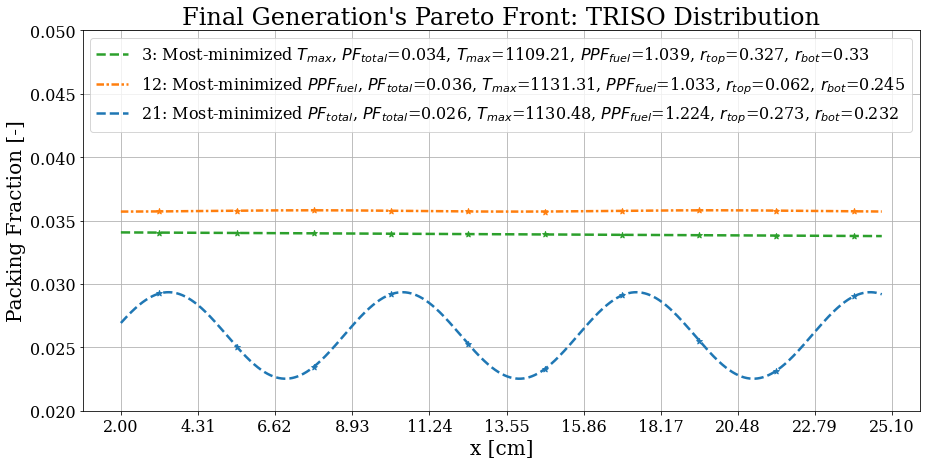

In [17]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
print("PF, TEMP, PPF", pf_min, temp_min, ppf_min)
fig, ax = plt.subplots(figsize=(15,7))
for i, ind in enumerate(non_dom):
    if i in [pf_min, temp_min, ppf_min]:
        print("gen, num", ind.gen, ind.num)
        print(i, ind)
        print("fitness", ind.fitness)
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*', color=colors[i])
        label = str(i+1) + ": "
        if i == pf_min:
            label += "Most-minimized $PF_{total}$"
        if i == temp_min:
            label += "Most-minimized $T_{max}$"
        if i == ppf_min:
            label += "Most-minimized $PPF_{fuel}$"
        label += ", $PF_{total}$="+str(round(ind.fitness.values[0],3)) +\
        ", $T_{max}$="+str(round(ind.fitness.values[1],2))+\
        ", $PPF_{fuel}$="+str(round(ind.fitness.values[2],3))+\
        ", $r_{top}$="+str(round(ind[4], 3))+\
        ", $r_{bot}$="+str(round(ind[5], 3))
        ax.plot(x1, sine1, alpha=1, linestyle=line_styles[i], color=colors[i], linewidth=2.5, label=label)
ax.grid()
ax.set_ylim(0.02,0.05)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=16, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=16)
ax.set_xlabel("x [cm]", fontsize=20)
ax.set_ylabel("Packing Fraction [-]", fontsize=20)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
plt.savefig("slab-obj-3-distr-most-minimized-all.png",bbox_inches='tight')

PF, TEMP, PPF 20 2 11
gen, num 1 42
PPF 1.0390783780774042
0 [0.03355109727351036, 0.12339696875557551, 1.338957581388841, 5.353138735368078, 0.0983910162702196, 0.09489301347276122]
fitness (0.03355109727351036, 1140.3329612413, 1.0390783780774042)
gen, num 3 11
PPF 1.0388884323922707
2 [0.03391651803967212, 0.6850989113274453, 0.0013246140522087235, 4.049471898105289, 0.3268821367193385, 0.3299094286320171]
fitness (0.03391651803967212, 1109.2110048711, 1.0388884323922707)
gen, num 5 29
PPF 1.0373227799607818
6 [0.03509763689108163, 0.03417998551926785, 1.3705227564747369, 5.224638090453406, 0.21581257484165056, 0.19651103330257808]
fitness (0.03509763689108163, 1123.7287772557, 1.0373227799607818)
gen, num 6 10
PPF 1.0568455768228844
8 [0.032298094940212733, 0.21930760419883233, 0.02778245398552507, 3.8340123549587357, 0.24709531607749674, 0.2600426260408727]
fitness (0.032298094940212733, 1119.627916082, 1.0568455768228844)
gen, num 6 11
PPF 1.0412304810297717
9 [0.0329715989280273

Text(0.5, 1.0, "Final Generation's Pareto Front: TRISO Distribution")

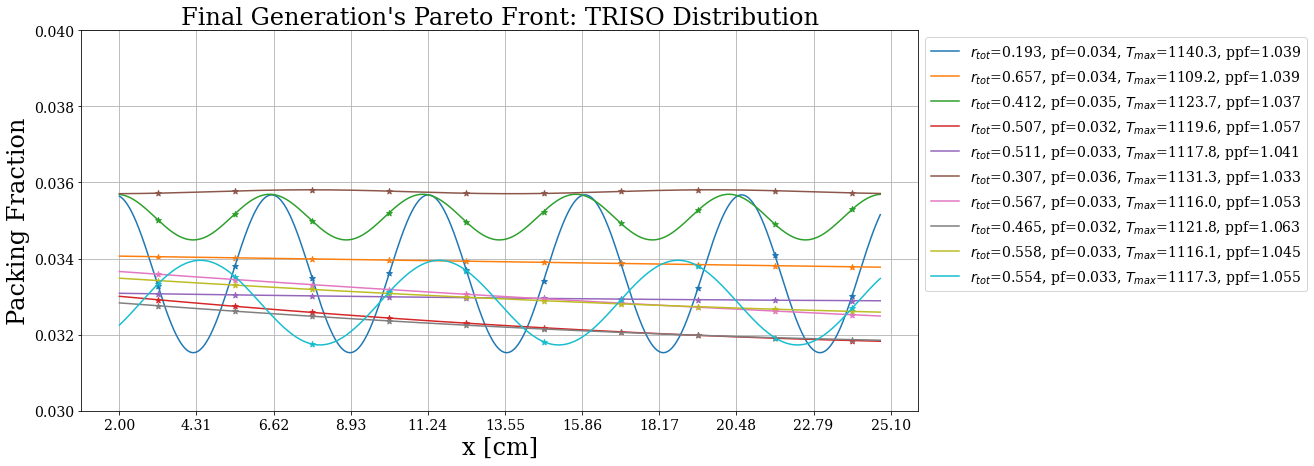

In [18]:
results = cp["all"]
pop = results["populations"][-1]
non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
obj_0 = np.array([item.fitness.values[0] for item in non_dom])
obj_1 = np.array([item.fitness.values[1] for item in non_dom])
obj_2 = np.array([item.fitness.values[2] for item in non_dom])
pf_min = np.argsort(obj_0)[0]
temp_min = np.argsort(obj_1)[0]
ppf_min = np.argsort(obj_2)[0]
print("PF, TEMP, PPF", pf_min, temp_min, ppf_min)
fig, ax = plt.subplots(figsize=(15,7))
for i, ind in enumerate(non_dom):
    if i in np.argsort(obj_2)[:10]:
        print("gen, num", ind.gen, ind.num)
        print("PPF", obj_2[i])
        print(i, ind)
        print("fitness", ind.fitness)
        x, sine, x1, sine1 = sine_curve(ind, True)
        ax.scatter(x, sine, marker='*')
        label = "$r_{tot}$="+str(round(ind[4]+ind[5], 3)) + ", pf="+str(round(ind.fitness.values[0],3))+", $T_{max}$="+str(round(ind.fitness.values[1],1))+", ppf="+str(round(ind.fitness.values[2],3))
        ax.plot(x1, sine1, alpha=1, label=label)
ax.grid()
ax.set_ylim(0.03,0.04)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14, bbox_to_anchor = [1.0, 1.0])
ax.set_xticks(np.arange(2,27.1,2.31))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel("x [cm]", fontsize=24)
ax.set_ylabel("Packing Fraction", fontsize=24)
ax.set_title("Final Generation's Pareto Front: TRISO Distribution", fontsize=24)
#plt.savefig("slab-obj-3-distr-most-minimized-all.png",bbox_inches='tight')

In [19]:
results = cp["all"]
ref = np.array([0.06, 1260 ,1.5])
for pop in results["populations"]:
    non_dom = tools.sortNondominated(pop, k=len(pop), first_front_only=True)[0]
    hypervol = bt.hypervolume(non_dom, ref)
    print(hypervol)

1.9852813826711488
2.119463807702002
2.158250333219014
2.2516908241608222
2.262718349248597
2.280846788403392
2.3103395710463643
2.3132830681891585
